# QClassify: a framework for implementing variational quantum classifiers

Here we present a concrete example showing how to use the subroutines of QClassify. We consider binary classification of points on 2D plane using a 2-qubit quantum circuit. In particular the data points are distributed in an XOR-like fashion:

<img src="xor.png" width="35%">

Here we encode a 2-dimensional vector $(\theta_1, \theta_2)$ into a 2-qubit state. For simplicity we set up the encoding such that the preprocessing step is trivial, namely each element of the data vector directly becomes a rotation angle on the circuit. A non-trivial classical preprocessing step may be found in for example [this paper](https://arxiv.org/abs/1806.08321). The circuit encoding is then $E(\boldsymbol\theta)=R_x(\theta_1)\otimes R_x(\theta_2)$. We then use a parametrized circuit $U({\bf w})$ to perform further classification.

The complete variational circuit is the following:

<img src="qnn_circuit.png" width="35%">

The encoding circuit serves as a feature map which maps a data point $(\theta_1,\theta_2)$ into a 2-qubit state. The second part is a processing circuit, which is a variational circuit with two parameters $w_1$ and $w_2$. The postprocessing steps consist of collecting the measurement statistics of the top qubit in the $Z$ basis and gleaning the probability $p$ of measuring $|1\rangle$ in the top qubit. The objective of training is to find a parameter setting ${\bf w}$ which minimizes the cross entropy between the circuit outputs on the training data and the training labels:
\begin{equation}
\sum_i-\ell_i\log(p_i)-(1-\ell_i)\log(1-p_i)
\end{equation}
where the sum is over the training set, $\ell_i\in\{0,1\}$ is the training label of the $i$-th data point and $p_i$ is the probability that the top qubit measures $|1\rangle$ for the $i$-th training point.

Now we describe step by step how to this up in QClassify. Before we start, note that the aim of this framework is to maximize customization. Therefore for a specific classification task the user can specify her own subroutines that suit the particular problem setting that is being considered.

First, we need to specify how classical data vectors are to be encoded in a quantum state. This is done in two parts:

1. Preprocess the classical data vector into circuit parameters. This is specified in `preprocessing.py`. For the purpose of this example we use the identity function `id_func` which simply returns the input.

2. For a given set of parameters $\bf w$, build an $n$-qubit circuit $E({\bf w})$ which prepares the state $E({\bf w})|0^n\rangle$. This is specified in `encoding_circ.py`. For the specific example considered here we have built the `x_product` function to realize the encoding circuit $E(\boldsymbol\theta)=R_x(\theta_1)\otimes\cdots\otimes R_x(\theta_n)$.

Having built these two functions, we specify the settings for encoding circuit in a dictionary as below.

In [1]:
from preprocessing import *
from encoding_circ import *

qencoder_options={
                'preprocessing':id_func,        # see preprocessing.py
                'encoding_circ':x_product,      # see encoding_circ.py
        }

We then move on to describe the processing of the encoded quantum state for classification. This is also a two-part effort:

1. Variational circuit $U({\bf w})$ for transforming the encoded state into a final state $|\boldsymbol\theta,{\bf w}\rangle$. This is specified in `proc_circ.py`. For the particular variational circuit used in this example we have built the function `layer_xz`. There is a specific template that a function should follow. The template is described in the doc string at the beginning of `proc_circ.py`.
2. Extracting information from the output state $|\boldsymbol\theta,{\bf w}\rangle$. This is specified in `postprocessing.py`. Here we have the opportunity to specify the measurements that are made to the output state, as well as any classical postprocessing functions that turn the measurement statistics into a class label. For this particular we use `measure_top` for specifying measurement on the top qubit and `prob_one` for computing the probability of measuring $|1\rangle$ as the classifier output.

Having constructed these functions, we specify the settings for processing of the encoded state in a dictionary below. Here under `'postprocessing'` tab the `'quantum'` entry is for measurements and `'classical'` is for classical postprocessing of measurement statistics.

In [2]:
from proc_circ import *
from postprocessing import *

qproc_options={
                'proc_circ':layer_xz,   # see proc_circ.py
                'postprocessing':{
                        'quantum':measure_top, # see postprocessing.py
                        'classical':prob_one, # see postprocessing.py
                }
        }

With all the components of the classifier specified we can now create a `QClassify` object which encapsulates all the information in the components. 

In [5]:
from qclassifier import QClassifier

qubits_chosen = [0, 1] # indices of the qubits that the circuit will act on
qclassifier_options = {
                'encoder_options':qencoder_options,
                'proc_options':qproc_options,
        }
qc = QClassifier(qubits_chosen, qclassifier_options)

So far the `QClassifier` contains only abstract information about the classifier. In order to obtain a concrete circuit, let's plug in concrete assignments of the input vector $\boldsymbol\theta$ and parameters ${\bf w}$.

In [7]:
input_vec = [1, 1] # input vector
params = [3.0672044712460114,\
          3.3311348339721203] # parameters for the circuit

qc_prog = qc.circuit(input_vec, params) # assign the input vector and parameters into the circuit
print(qc_prog)

RX(1) 0
RX(1) 1
CZ 0 1
RX(3.0672044712460114) 0
RX(3.3311348339721203) 1
DECLARE ro BIT[1]
MEASURE 0 ro[0]



The `circuit` method of the `QClassifier` object not only returns a concrete circuit with input vectors and parameters assignments, but also stores the circuit information internally. This allows one to execute the quantum classifier and return a particular classification output. 

In [8]:
prob = qc.execute()
print(prob)

0.7925


In addition if we would like to show the decision boundary of the classifier for a particular pair of features in the input vector we can use the `plot_decision_boundary` function. 

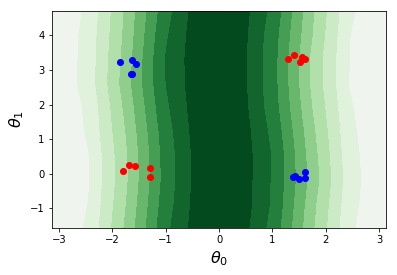

In [9]:
input_vec = [0,0]   # Input vector. Here [0,0] is used only as a placeholder since both features are chosen to be
                    # swept over.
features_chosen = [0,1] # Indices of features that are chosen. Here there are only two features so naturally we let it
                    # be [0,1].
filename = 'qclassifier_db.pdf' # name of the plot to be saved

plot_db_options = {     
                'nmesh':10,      # number of grid points
                'xmin':-pi,     # min. limit on the x axis
                'xmax':pi,      # max. limit on the x axis
                'ymin':-pi/2,   # min. limit on the y axis
                'ymax':3*pi/2   # max. limit on the y axis
        }

qc.plot_decision_boundary(input_vec, features_chosen, filename, plot_db_options)

From the above decision boundary plot we can see that apparently the classifier is not doing a great job in separating the data points. Therefore we need to tune the parameters to improve it. The standard training objective function is the cross entropy (see `crossentropy` in `training.py`). The training data needs to be provided as a Python list of tuples `(features, label)` where `features` is a list of floating point numbers and `label` is either 0 or 1. 

In [12]:
from xor_example import *
from training import *

train_options={
                'training_data':gen_xor(),      # Example. See xor_example.py
                'objective_func':crossentropy,  # See training.py
                'training_method':'nelder-mead', # Optimization algorithm
                'init_params':[3.0672044712460114, 3.3311348339721203], # initial guess for parameters
                'maxiter':20, # maximum number of iterations
                'xatol':1e-3, # tolerance in solution
                'fatol':1e-3, # tolerance in function value
                'verbose':True # Print intermediate values
        }

qc.train()

Iter   Obj
   1   0.357
   2   0.042
   3   0.044
   4   0.043
   5   0.031
   6   0.013
   7   0.013
   8   0.014
   9   0.013
  10   0.013
  11   0.013
  12   0.013
  13   0.013
  14   0.013
  15   0.013
  16   0.013
  17   0.013
  18   0.013
  19   0.013


The `min_loss_history` attribute of `QClassifier` class stores the value of the objective function each time it is called during the optimization. This may be used for further processing (for example plotting the training curve).

In [13]:
print(qc.min_loss_history)

[0.3571691420108378, 0.042378109951297545, 0.04370601048034206, 0.04274844562135506, 0.030973006771868754, 0.013296563509172873, 0.013421991560888274, 0.013597117978841269, 0.01324762068519703, 0.012508858957018587, 0.012789812486771811, 0.013190031704530794, 0.013158101725498032, 0.013346240689243099, 0.013004018333895117, 0.013067149174096881, 0.012883551463942539, 0.013270887810348977, 0.013204975219177961]


After training we again plot the decision boundary. It seems that the classifier is able to perform much better on the training data.

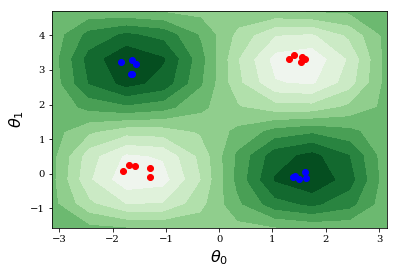

In [15]:
qc.plot_decision_boundary([0,0],[0,1],'qclassifier_db_train.pdf',plot_db_options)